In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

# submission
from tqdm import tqdm
import pandas as pd
from pandas import DataFrame

## **Define ResNet model**

In [3]:
class BasicBlock(nn.Module):
    expansion = 1   # output 채널을 늘리고싶다면 1보다 큰 값으로
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정합니다.
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion),
        )

        # identity mapping, input과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        # projection mapping using 1x1conv, input과 output의 feature map size가 다를 경우 사용
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x


class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        # identity mapping
        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()
        
        # projection mapping
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=100, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

# 34 = 1(7x7 conv) + 2 * (3 + 4 + 6 + 3) + 1(fc 1000)
def resnet34():
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

# 50 = 1(7x7 conv) + 3 * (3 + 4 + 6 + 3) + 1(fc 1000)
def resnet50():
    return ResNet(BottleNeck, [3, 4, 6, 3], num_classes=num_classes)

def resnet101():
    return ResNet(BottleNeck, [3, 4, 23, 3], num_classes=num_classes)

def resnet152():
    return ResNet(BottleNeck, [3, 8, 36, 3], num_classes=num_classes)

## **Utils**

In [5]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

## **Cutout: Main Code for Applying Cutout data augmentation**

In [6]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

## **Parameter Setting**

In [18]:
dataset = 'cifar10' # cifar10 or cifar100
model = 'ResNet34' # resnet18, resnet50, resnet101, GoogLeNetV1
batch_size = 64  # Input batch size for training (default: 128)
epochs = 5 # Number of epochs to train (default: 200)
learning_rate = 0.001 # Learning rate
data_augmentation = True # Traditional data augmentation such as augmantation by flipping and cropping?
path2weights = '/content/drive/Shareddrives/Data/Kaggle/GEK6189_CIFAR-10_Competition_2022-1/models/'+model+'.pth'    # route for model saving
path2LatestWeights = '/content/drive/Shareddrives/Data/Kaggle/GEK6189_CIFAR-10_Competition_2022-1/models/'+model+'_latest.pth'    # route for latest model saving
path2submission = '/content/drive/Shareddrives/Data/Kaggle/GEK6189_CIFAR-10_Competition_2022-1/submission/'+model+'.csv'

cutout = False # Apply Cutout?
if cutout:
    n_holes = 1 # Number of holes to cut out from image
    length = 16 # Length of the holes

seed = 0 # Random seed (default: 0)
print_freq = 100
cuda = torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

test_id = dataset + '_' + model

In [8]:
# Image Preprocessing
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

# train
train_transform = transforms.Compose([])

train_transform.transforms.append(transforms.Resize((64, 64)))
if data_augmentation:
    #train_transform.transforms.append(transforms.RandomCrop(299, 299))
    train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(normalize)

if cutout:
    train_transform.transforms.append(Cutout(n_holes=n_holes, length=length))

# test
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    normalize])


# load dataset
if dataset == 'cifar10':
    num_classes = 10
    train_dataset = datasets.CIFAR10(root='data/',
                                     train=True,
                                     transform=train_transform,
                                     download=True)

    test_dataset = datasets.CIFAR10(root='data/',
                                    train=False,
                                    transform=test_transform,
                                    download=True)

Files already downloaded and verified
Files already downloaded and verified


## **Validation set**

In [9]:
from torch.utils.data import random_split

val_size = 5000
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
len(train_dataset), len(val_dataset)

(45000, 5000)

## **DataLoader**

In [10]:
# Data Loader (Input Pipeline)
train_loader = DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

val_loader = DataLoader(dataset=val_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

test_loader = DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          pin_memory=True,
                                          num_workers=2)

## **Show sample image**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


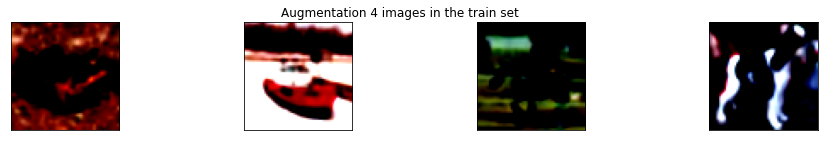

In [11]:
x_train, x_train_label = [],[]
for i in range(4):
  img,label = train_dataset[i]
  x_train.append(img)
  x_train_label.append(label)

plt.figure(figsize=(16,2))
plt.suptitle("Augmentation 4 images in the train set")
for i in range(4):
  plt.subplot(1,4,i+1)
  x_train_tr = np.transpose(x_train[i], (1, 2, 0))
  plt.imshow(x_train_tr)
  plt.xticks([]); plt.yticks([])

## **Main Training**

In [35]:
def train(train_loader, epoch, model, optimizer, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses,
                             top1, top5, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        input = input.cuda()
        target = target.cuda()
        #input = input.to(torch.device("cpu"))
        #target = target.to(torch.device("cpu"))

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss, accuracy 
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), input.size(0))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)

    print('==> Train Accuracy: Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

def valid(val_loader, model):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    model.eval()
    for i,(input,target) in enumerate(val_loader):
        input = input.cuda()
        target = target.cuda()
        #input = input.to(torch.device("cpu"))
        #target = target.to(torch.device("cpu"))

        output = model(input)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        top1.update(acc1[0].item(), input.size(0))
        top5.update(acc5[0].item(), input.size(0))
    print('==> Valid Accuracy:  Acc@1 {top1.avg:.3f} || Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    return top1.avg

def test(test_loader, model):
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    model.eval()
    for i, (input, target) in enumerate(tqdm(test_loader), 0):
        input = input.cuda()
        #target은 쓰지 않음.
        #target = target.cuda()

        output = torch.argmax(model(input), 1)
        
        id = i * batch_size + 1     # id는 1부터 시작
        lst = []
        
        for Id, Category in zip(range(id, id+batch_size), output):
            x = Category.to("cpu").numpy()
            Category = x.astype(int)
            lst.append([Id, classes[Category]])

        df = DataFrame(lst, columns=['Id', 'Category'])
        if i == 0:
            df.to_csv(path2submission, index=False, encoding='cp949')
        else :
            df.to_csv(path2submission, mode='a', index=False, encoding='cp949', header=False)

In [13]:
model = resnet34().cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss(reduction='sum').cuda()

In [14]:
best_acc = 0
for epoch in range(epochs):
    print("\n----- epoch: {}/{}, lr: {} -----".format(
        epoch+1, epochs, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer, criterion)
    val_acc = valid(val_loader, model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc < val_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), path2weights)

torch.save(model.state_dict(), path2LatestWeights)
print(f"Best Top-1 Accuracy: {best_acc}")


----- epoch: 1/5, lr: 0.001 -----
Epoch: [0][  0/704]	Time  1.591 ( 1.591)	Loss 1.4665e+02 (1.4665e+02)	Acc@1   7.81 (  7.81)	Acc@5  60.94 ( 60.94)
Epoch: [0][100/704]	Time  0.123 ( 0.171)	Loss 1.0296e+02 (1.1805e+02)	Acc@1  48.44 ( 30.74)	Acc@5  90.62 ( 83.08)
Epoch: [0][200/704]	Time  0.122 ( 0.147)	Loss 9.4144e+01 (1.1030e+02)	Acc@1  40.62 ( 35.74)	Acc@5  96.88 ( 86.47)
Epoch: [0][300/704]	Time  0.122 ( 0.138)	Loss 7.8506e+01 (1.0508e+02)	Acc@1  54.69 ( 38.91)	Acc@5  92.19 ( 88.17)
Epoch: [0][400/704]	Time  0.123 ( 0.136)	Loss 7.9826e+01 (1.0112e+02)	Acc@1  53.12 ( 41.51)	Acc@5  95.31 ( 89.35)
Epoch: [0][500/704]	Time  0.128 ( 0.138)	Loss 6.9916e+01 (9.7938e+01)	Acc@1  60.94 ( 43.61)	Acc@5  92.19 ( 90.06)
Epoch: [0][600/704]	Time  0.121 ( 0.137)	Loss 8.6445e+01 (9.5275e+01)	Acc@1  54.69 ( 45.33)	Acc@5  93.75 ( 90.73)
Epoch: [0][700/704]	Time  0.121 ( 0.135)	Loss 7.8872e+01 (9.2610e+01)	Acc@1  54.69 ( 46.96)	Acc@5  96.88 ( 91.36)
==> Train Accuracy: Acc@1 46.991 || Acc@5 91.364
==> 

## **Test data**

In [36]:
final_model = resnet34().cuda()
final_model.load_state_dict(torch.load('/content/drive/Shareddrives/Data/Kaggle/GEK6189_CIFAR-10_Competition_2022-1/models/ResNet34.pth'))
test(test_loader, final_model)

100%|██████████| 157/157 [00:08<00:00, 18.36it/s]
